<div style="background:#FFFFAA">
<img src="nhanes.jpg", width=150, border=20>
<h1>Survival Starting Kit </h1>
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p>
    <span style="color:red">  </span>
     <br>
In this challenge we try to tackle a survival analysis problem from a machine learning perspective. The goal of survival analysis is to predict the expected time before a given event occur. In our case we try to estimate the survival time of patients given some data from the NHANES dataset. 

Special thanks to our coordinators Kristin Bennett, Alexander New and Andrew for providing a clean aggregated version of the dataset.
 <br>
    <span style="color:red">  </span>
</div>

In [1]:
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
#model_dir = '../FILES/pretty_good_sample_code_submission/'
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
    <span style="color:red">  </span>
</div>

In [2]:
data_dir = 'public_data'              # Change this to the directory where you put the input data
data_name = 'Mortality'
!dir $data_dir*

Mortality_feat.name    Mortality_test.data	 Mortality_valid.data
Mortality_label.name   Mortality_train.data
Mortality_public.info  Mortality_train.solution


For convenience, we load the data as a "pandas" data frame, so we can use "pandas" and "seaborn" built in functions to explore the data.

In [3]:
from data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)
print(data.shape)# The data are loaded as a Pandas Data Frame

Reading public_data/Mortality_train from AutoML format
Number of examples = 19297
Number of features = 10
(19297, 10)
(19297, 2)
(19297, 12)


Each row is a patient represented by more than 600 features the first of which are:
- age : the patient's age 
- sbp : systolic blood pressure
- dbp : diastolic blood pressure
- A1c : glycated hemoglobin concentration (A1c test)
- bmi : body mass index
- gender_male : patient's gender, 0 female, 1 male

The initial data contained an ethnicity feature that has been one hot encoded so that the data can be used by models that don't allow categorical data:
- ethnicity_NonHispanicBlack : 1 for african american
- ethnicity_NonHispanicWhite : 1 for white ethnicity 
- ethnicity_Other : 1 for neither african american, white or hispanic
- ethnicity_OtherHispanic : 1 for hispanic

The two last columns target and event are the labels.
- target : the survival time to predict 
- event : if the data is censored (the patient left the study) 1 else 0 

The other features meaning are available on the NHANES website.

In [4]:
data.head()

,age,sbp,dbp,A1c,bmi,gender_male,ethnicity_NonHispanicBlack,ethnicity_NonHispanicWhite,ethnicity_Other,ethnicity_OtherHispanic,target,event
0,71,98.666667,60.666667,5.3,29.68,1,0,1,0,0,63.0,0.0
1,49,130.666667,89.333333,5.5,18.85,1,1,0,0,0,78.0,0.0
2,48,122.000000,74.666667,5.9,36.16,0,1,0,0,0,112.0,0.0
3,19,102.000000,61.333333,5.3,21.17,1,1,0,0,0,138.0,0.0
4,28,107.000000,59.000000,4.8,29.82,0,0,1,0,0,61.0,0.0


The pandas describe() function give us a quick overview of the data statistics

In [5]:
data.describe() 

,age,sbp,dbp,A1c,bmi,gender_male,ethnicity_NonHispanicBlack,ethnicity_NonHispanicWhite,ethnicity_Other,ethnicity_OtherHispanic,target,event
count,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000,19297.000000
mean,46.632793,124.188492,69.254426,5.570083,28.246865,0.483650,0.202156,0.479142,0.038192,0.057781,89.611235,0.098720
std,19.854414,20.036147,13.843717,1.013537,6.344524,0.499746,0.401618,0.499578,0.191666,0.233335,35.819216,0.298293
min,18.000000,72.666667,0.000000,2.000000,12.040000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,29.000000,110.666667,62.000000,5.100000,23.850000,0.000000,0.000000,0.000000,0.000000,0.000000,58.000000,0.000000
50%,45.000000,120.666667,70.000000,5.400000,27.340000,0.000000,0.000000,0.000000,0.000000,0.000000,88.000000,0.000000
75%,63.000000,134.000000,77.333333,5.700000,31.530000,1.000000,0.000000,1.000000,0.000000,0.000000,121.000000,0.000000
max,85.000000,270.000000,132.000000,18.800000,130.210000,1.000000,1.000000,1.000000,1.000000,1.000000,153.000000,1.000000


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split

In the next cell, we plot histograms of survival time for censored (0) and uncensored (1) examples.

We can see that there are no examples of censored example with a low survival time. We can also see that there are more censored data than uncensored

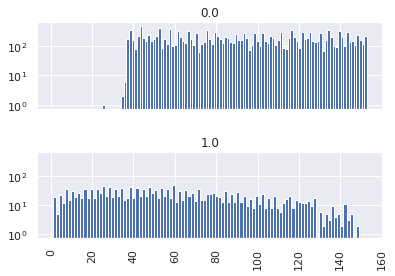

In [7]:
ax=data.hist(column='target', by='event', bins=100, layout=(2,1), log=True, sharex=True, sharey=True)

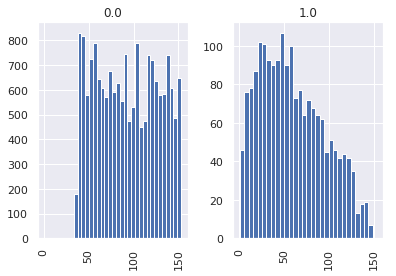

In [8]:
# Better visualise the difference 
ax = data.hist(column='target', by=['event'], bins=30, sharex=True)

We have around 90% of censored data.

In [9]:
df2 = data.loc[data['event'] == 1]
nb_uncensored = len(df2)
print('Number of uncensored examples : '+str(nb_uncensored))
df2 = data.loc[data['event'] == 0]
nb_censored = len(df2)
print('Number of censored examples : '+str(nb_censored))
print(nb_censored / (nb_uncensored + nb_censored))

Number of uncensored examples : 1905
Number of censored examples : 17392
0.9012799917085558


We next plot the same histograms by gender (0 female, 1 male), male survival seems slightly lower.


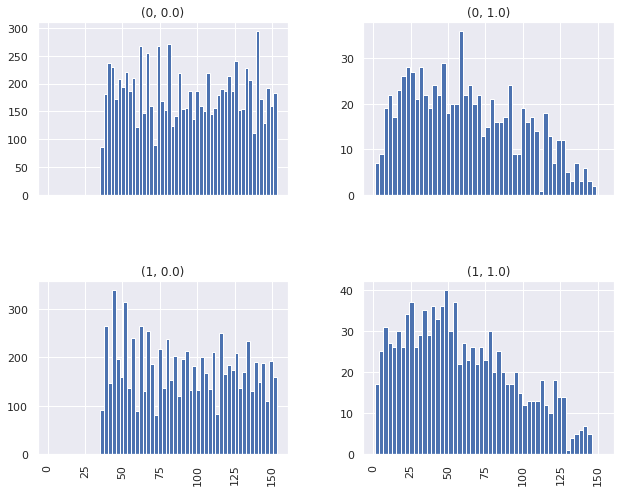

In [10]:
# Lifetime distribution by gender 
ax = data.hist(column='target', by=['gender_male','event'], bins=50
             ,sharex=True, figsize=(10,8))

<div style="background:#FFFFAA">
<h1>Step 2: Building a predictive model</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:
   <br>     <span style="color:red"> </span>
</div>

In [11]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)
print(D)

Info file found : /home/steven/projects/ghosts/starting_kit/public_data/Mortality_public.info
DataManager : Mortality
info:
	usage = Continuous NHANES Mortality data
	name = mortality
	task = multilabel.classification
	target_type = Numerical
	feat_type = Numerical
	metric = concordance_index
	time_budget = 1200
	feat_num = 11
	target_num = 1
	label_num = 2
	train_num = 19297
	valid_num = 2171
	test_num = 2412
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
data:
	X_train = array(19297, 10)
	Y_train = array(19297, 2)
	X_valid = array(2413, 10)
	Y_valid = array(0,)
	X_test = array(2412, 10)
	Y_test = array(0,)
feat_type:	array(11,)
feat_idx:	array(0,)



<div style="background:#FFFFAA">
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

In [12]:
from data_io import write
from model import model
import pickle
import numpy as np   # We recommend to use numpy arrays
from os.path import isfile
from sklearn.base import BaseEstimator
from sklearn import preprocessing
#import UnitTest as Test
import zPreprocessing as zprepro

/home/steven/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<div style="background:#FFFFAA">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:

To build custom model you can edit the model.py we gave you and zip it with the metadata file so you can make a submission. You can also test the model here. 
</div>

In [13]:
# Instantiate you model 
M = model()

In [14]:
if not(M.is_trained):
    X_train = D.data['X_train']
    Y_train = D.data['Y_train']
    #M.fit(X_train, Y_train
    #X = zprepro.zePreproDeLaMort.fit_transform(X_train)
    M.fit(X_train,Y_train)
Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on training examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])

Y_valid = D.data['Y_valid']
Y_test = D.data['Y_test']


FIT: dim(X)= [19297, 10]
FIT: dim(y)= [19297, 2]
PREDICT: dim(X)= [19297, 10]
PREDICT: dim(y)= [19297, 2]
DEBUG : (19297,)
PREDICT: dim(X)= [2413, 10]
PREDICT: dim(y)= [2413, 2]
DEBUG : (2413,)
PREDICT: dim(X)= [2412, 10]
PREDICT: dim(y)= [2412, 2]
DEBUG : (2412,)


In [15]:
"""
Test unitaires
"""
"""
def testPredict(): #inspire du group Survivers
    for i in range (X_train.shape[0]):
        if X_train[i,X_train.shape[1]-1] == 0 :
            return True 
    return False
        
print(testPredict())

def testCompatibilityTrain():
    return X_train.shape[0] == Y_train.shape[0]
                            
def testCompatibility():
    return Y_valid.shape[0] == Y_test.shape[0]
print(testCompatibilityTrain())
print(testCompatibility())

def testPrepro(): #il marche pas trop bien
        prepro = zprepro.zePreproDeLaMort()
        fitTab = zprepro.zePreproDeLaMort.fit(np.loadtxt("public_data/Mortality_train.data", delimiter=" "))
        transformTab = zprepro.transform(fitTab)
        fitArray = list_to_array(fitTab)
        transformTab = transform(fitTab, filename1)
        transformArray = list_to_array(transformTab) 
#testPrepro()
"""

'\ndef testPredict(): #inspire du group Survivers\n    for i in range (X_train.shape[0]):\n        if X_train[i,X_train.shape[1]-1] == 0 :\n            return True \n    return False\n        \nprint(testPredict())\n\ndef testCompatibilityTrain():\n    return X_train.shape[0] == Y_train.shape[0]\n                            \ndef testCompatibility():\n    return Y_valid.shape[0] == Y_test.shape[0]\nprint(testCompatibilityTrain())\nprint(testCompatibility())\n\ndef testPrepro(): #il marche pas trop bien\n        prepro = zprepro.zePreproDeLaMort()\n        fitTab = zprepro.zePreproDeLaMort.fit(np.loadtxt("public_data/Mortality_train.data", delimiter=" "))\n        transformTab = zprepro.transform(fitTab)\n        fitArray = list_to_array(fitTab)\n        transformTab = transform(fitTab, filename1)\n        transformArray = list_to_array(transformTab) \n#testPrepro()\n'

<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

<div style="background:#FFFFAA">
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [16]:
#Uncomment if you want to save the model and or save the results
#M.save(trained_model_name)                 
#result_name = result_dir + data_name
#from data_io import write
#write(result_name + '_train.predict', Y_hat_train)
#write(result_name + '_valid.predict', Y_hat_valid)
#write(result_name + '_test.predict', Y_hat_test)
#!ls $result_name*

<div style="background:#FFFFAA">
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

In [17]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
print('The metric is between 0 and 1. The higher the better')

Using scoring metric: custom_c_index
The metric is between 0 and 1. The higher the better


<div style="background:#FFFFAA">
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

In [18]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
#print('Valid score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_valid, Y_hat_valid))
#print('Test score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_test, Y_hat_test))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train[:,0]))

Training score for the custom_c_index metric = 0.5195
Ideal score for the custom_c_index metric = 1.0000


<div style="background:#FFFFAA">
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [19]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

FIT: dim(X)= [15437, 10]
FIT: dim(y)= [15437, 2]
PREDICT: dim(X)= [3860, 10]
PREDICT: dim(y)= [3860, 2]
DEBUG : (3860,)
FIT: dim(X)= [15437, 10]
FIT: dim(y)= [15437, 2]
PREDICT: dim(X)= [3860, 10]
PREDICT: dim(y)= [3860, 2]
DEBUG : (3860,)
FIT: dim(X)= [15438, 10]
FIT: dim(y)= [15438, 2]
PREDICT: dim(X)= [3859, 10]
PREDICT: dim(y)= [3859, 2]
DEBUG : (3859,)
FIT: dim(X)= [15438, 10]
FIT: dim(y)= [15438, 2]
PREDICT: dim(X)= [3859, 10]
PREDICT: dim(y)= [3859, 2]
DEBUG : (3859,)
FIT: dim(X)= [15438, 10]
FIT: dim(y)= [15438, 2]
PREDICT: dim(X)= [3859, 10]
PREDICT: dim(y)= [3859, 2]
DEBUG : (3859,)

CV score (95 perc. CI): 0.50 (+/- 0.03)


In [31]:
#cross_val_score??

def getScoresCV(x,y):
    tab= []
    for i in range(1,8):
        M = model(i)
        scores = cross_val_score(M, x, y, cv=5,scoring = make_scorer(scoring_function))
        temp = (scores.mean(), scores.std() * 2)
        print("temp",temp)
        tab.append(temp)
    return tab
t =getScoresCV(X_train, Y_train)
"""
def getScoresMAXDEPTH(x,y):
    from sklearn.tree import DecisionTreeRegressor
    tab=[]
    for i in range(0,10):
        M = DecisionTreeRegressor(max_depth = i)
        scores = cross_val_score(M, x,y, cv=5,scoring = make_scorer(scoring_function) )
        temp = (scores.mean(), scores.std() * 2)
        tab.append(temp)
    return tab
t2 = getScoresMAXDEPTH(X_train,Y_train) 
"""

FIT: dim(X)= [15437, 10]
FIT: dim(y)= [15437, 2]
PREDICT: dim(X)= [3860, 10]
PREDICT: dim(y)= [3860, 2]
DEBUG : (3860,)
FIT: dim(X)= [15437, 10]
FIT: dim(y)= [15437, 2]
PREDICT: dim(X)= [3860, 10]
PREDICT: dim(y)= [3860, 2]
DEBUG : (3860,)
FIT: dim(X)= [15438, 10]
FIT: dim(y)= [15438, 2]
PREDICT: dim(X)= [3859, 10]
PREDICT: dim(y)= [3859, 2]
DEBUG : (3859,)
FIT: dim(X)= [15438, 10]
FIT: dim(y)= [15438, 2]
PREDICT: dim(X)= [3859, 10]
PREDICT: dim(y)= [3859, 2]
DEBUG : (3859,)
FIT: dim(X)= [15438, 10]
FIT: dim(y)= [15438, 2]
PREDICT: dim(X)= [3859, 10]
PREDICT: dim(y)= [3859, 2]
DEBUG : (3859,)
temp (0.6291754748651572, 0.3798818923158386)
FIT: dim(X)= [15437, 10]
FIT: dim(y)= [15437, 2]
PREDICT: dim(X)= [3860, 10]
PREDICT: dim(y)= [3860, 2]
DEBUG : (3860,)
FIT: dim(X)= [15437, 10]
FIT: dim(y)= [15437, 2]
PREDICT: dim(X)= [3860, 10]
PREDICT: dim(y)= [3860, 2]
DEBUG : (3860,)
FIT: dim(X)= [15438, 10]
FIT: dim(y)= [15438, 2]
PREDICT: dim(X)= [3859, 10]
PREDICT: dim(y)= [3859, 2]
DEBUG : (3

'\ndef getScoresMAXDEPTH(x,y):\n    from sklearn.tree import DecisionTreeRegressor\n    tab=[]\n    for i in range(0,10):\n        M = DecisionTreeRegressor(max_depth = i)\n        scores = cross_val_score(M, x,y, cv=5,scoring = make_scorer(scoring_function) )\n        temp = (scores.mean(), scores.std() * 2)\n        tab.append(temp)\n    return tab\nt2 = getScoresMAXDEPTH(X_train,Y_train) \n'

In [43]:
m = model()
scores = cross_val_score(m, X_train, Y_train, cv=5,scoring = make_scorer(scoring_function))
temp = (scores.mean(), scores.std() * 2)
print(temp)

FIT: dim(X)= [15437, 10]
FIT: dim(y)= [15437, 2]
PREDICT: dim(X)= [3860, 10]
PREDICT: dim(y)= [3860, 2]
DEBUG : (3860,)
FIT: dim(X)= [15437, 10]
FIT: dim(y)= [15437, 2]
PREDICT: dim(X)= [3860, 10]
PREDICT: dim(y)= [3860, 2]
DEBUG : (3860,)
FIT: dim(X)= [15438, 10]
FIT: dim(y)= [15438, 2]
PREDICT: dim(X)= [3859, 10]
PREDICT: dim(y)= [3859, 2]
DEBUG : (3859,)
FIT: dim(X)= [15438, 10]
FIT: dim(y)= [15438, 2]
PREDICT: dim(X)= [3859, 10]
PREDICT: dim(y)= [3859, 2]
DEBUG : (3859,)
FIT: dim(X)= [15438, 10]
FIT: dim(y)= [15438, 2]
PREDICT: dim(X)= [3859, 10]
PREDICT: dim(y)= [3859, 2]
DEBUG : (3859,)
(0.5006507199010883, 0.025544294288654054)


[0 1 2 3 4 5 6 7]
[0.62917547 0.49660818 0.48719226 0.22087034 0.79636551 0.53480002
 0.50055082 0.50065072]


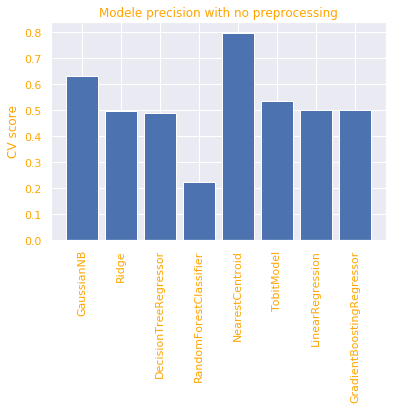

In [63]:
import matplotlib.pyplot as plt
bars = ('GaussianNB', 'Ridge', 'DecisionTreeRegressor', 'RandomForestClassifier','NearestCentroid', 
        'TobitModel', 'LinearRegression','GradientBoostingRegressor')  
x_graph = np.arange(len(bars))        
print(x_graph)
y_graph =[]
for i in t:
    y_graph.append(i[0])
y_graph.append(temp[0])
y_graph = np.array(y_graph)
print(y_graph)
fig, ax = plt.subplots()
ax.set_ylabel("CV score",color ='orange')
ax.bar(x_graph,y_graph)
plt.title("Modele precision with no preprocessing",color='orange')
plt.xticks(x_graph, bars, rotation=90,color='orange')
plt.yticks(color='orange')
#for i in range(len(bars)):
 #   plt.text(x= "aaaa", y="bbb",s= y_graph[i], size =6)
plt.show()


<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [22]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

/bin/sh: 1: source: not found
Using input_dir: /home/steven/projects/ghosts/starting_kit/public_data
Using output_dir: /home/steven/projects/ghosts/starting_kit/sample_result_submission
Using program_dir: /home/steven/projects/ghosts/starting_kit/ingestion_program
Using submission_dir: /home/steven/projects/ghosts/starting_kit/sample_code_submission
/home/steven/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d

========== Ingestion program version 6 ==========

************************************************
******** Processing dataset Mortality ********
************************************************
========= Reading and converting data ==========
Info file found : /home/steven/projects/ghosts/starting_kit/public_data/Mortality_public.info
========= Reading /home/ste

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [23]:
scoring_output_dir = '../scoring_output_dir'
#!source activate python3; 
!python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

======= Set 1 (Mortality_train): custom_c_index(set1_score)=0.519518766999 =======


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [24]:
#0.519518766999

import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = '../sample_code_submission_' + the_date + '.zip'
sample_result_submission = '../sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)

Submit one of these files:
../sample_code_submission_19-03-31-16-04.zip
../sample_result_submission_19-03-31-16-04.zip
